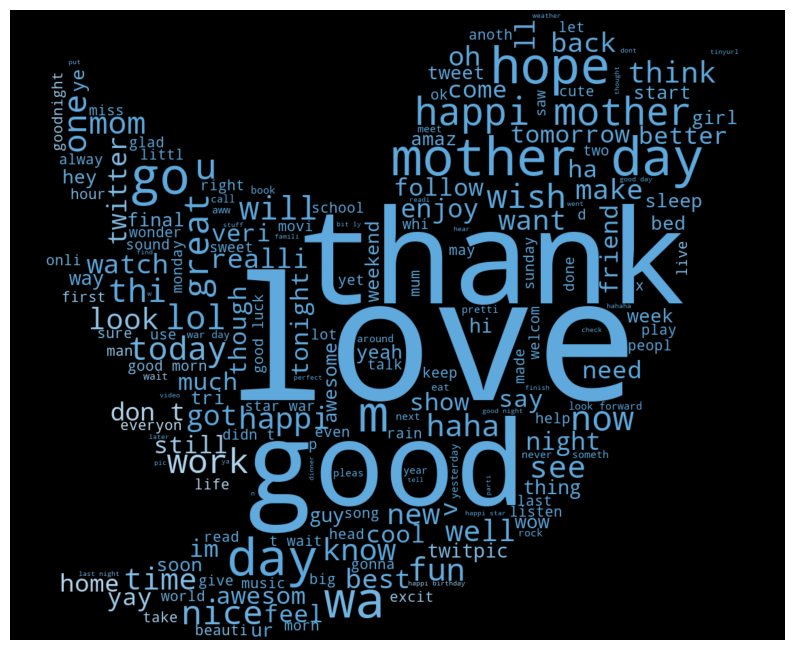

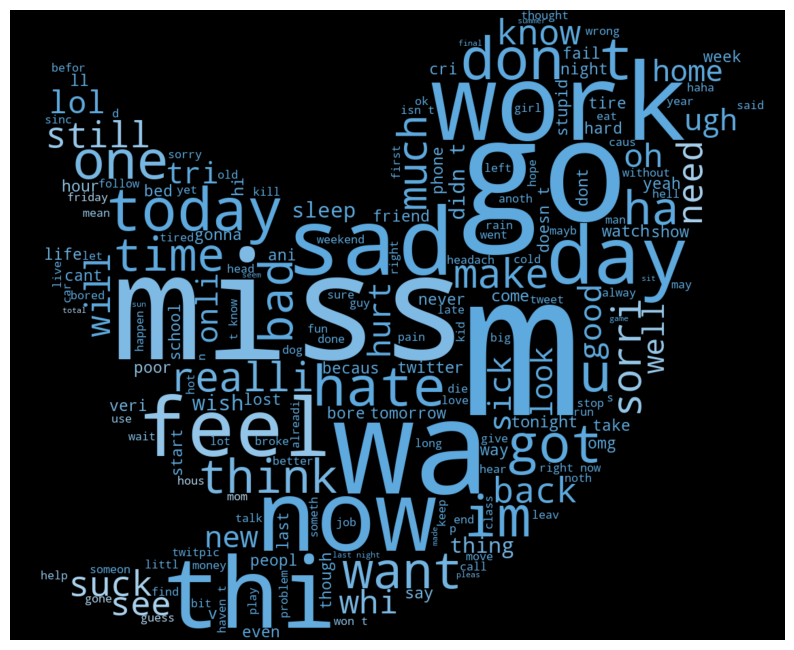

                                                text sentiment
0  Last session of the day  http://twitpic.com/67ezh   neutral
1   Shanghai is also really exciting (precisely -...  negative
2  Recession hit Veronique Branquinho, she has to...  negative
3                                        happy bday!  negative
4             http://twitpic.com/4w75p - I like it!!   neutral


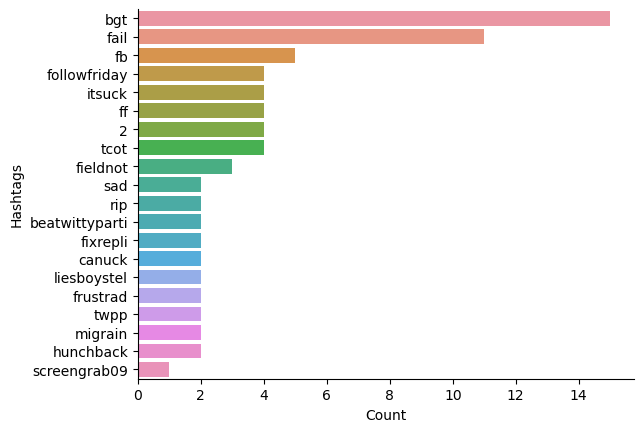

In [10]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import requests

# Ignore warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Read in the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Combine train and test data
combined_data = pd.concat([train, test], ignore_index=True, sort=True)

# Function to remove patterns like @mentions
def remove_pattern(text, pattern):
    if not isinstance(text, str):  # Check if the text is not a string (e.g., NaN)
        return ''  # Return an empty string for non-string entries
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, "", text)
    return text

# Clean the text by removing @mentions and other unwanted characters
combined_data['text'] = combined_data['text'].fillna('')  # Fill NaN values with an empty string
combined_data['Cleaned_Text'] = np.vectorize(remove_pattern)(combined_data['text'], "@[\w]*")

# Tokenize the tweets
tokenized_tweets = combined_data['Cleaned_Text'].apply(lambda x: x.split())

# Apply stemming
from nltk import PorterStemmer
ps = PorterStemmer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [ps.stem(i) for i in x])

# Join the tokens back into cleaned text
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])

combined_data['Cleaned_Text'] = tokenized_tweets

# Create word clouds for sentiment categories
positive_words = ' '.join(text for text in combined_data['Cleaned_Text'][combined_data['sentiment'] == 'positive'])
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
image_color = ImageColorGenerator(Mask)
wc = WordCloud(background_color='black', height=1500, width=4000, mask=Mask).generate(positive_words)
plt.figure(figsize=(10, 20))
plt.imshow(wc.recolor(color_func=image_color), interpolation="hamming")
plt.axis('off')
plt.show()

negative_words = ' '.join(text for text in combined_data['Cleaned_Text'][combined_data['sentiment'] == 'negative'])
wc = WordCloud(background_color='black', height=1500, width=4000, mask=Mask).generate(negative_words)
plt.figure(figsize=(10, 20))
plt.imshow(wc.recolor(color_func=image_color), interpolation="hamming")
plt.axis('off')
plt.show()

# Extract hashtags
def extractHashtags(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

positive_hashtags = extractHashtags(combined_data['Cleaned_Text'][combined_data['sentiment'] == 'positive'])
positive_hashtags_unnested = sum(positive_hashtags, [])

negative_hashtags = extractHashtags(combined_data['Cleaned_Text'][combined_data['sentiment'] == 'negative'])
negative_hashtags_unnested = sum(negative_hashtags, [])

# Plot top hashtags
positive_word_freq = nltk.FreqDist(positive_hashtags_unnested)
positive_df = pd.DataFrame({'Hashtags': list(positive_word_freq.keys()), 'Count': list(positive_word_freq.values())})
positive_df_plot = positive_df.nlargest(20, columns='Count')
sns.barplot(data=positive_df_plot, y='Hashtags', x='Count')
sns.despine()

negative_word_freq = nltk.FreqDist(negative_hashtags_unnested)
negative_df = pd.DataFrame({'Hashtags': list(negative_word_freq.keys()), 'Count': list(negative_word_freq.values())})
negative_df_plot = negative_df.nlargest(20, columns='Count')
sns.barplot(data=negative_df_plot, y='Hashtags', x='Count')
sns.despine()

# Vectorizing the tweets (BoW and TF-IDF)
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")
bow = bow_vectorizer.fit_transform(combined_data['Cleaned_Text'])
bow_df = pd.DataFrame(bow.todense())

tfidf = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(combined_data['Cleaned_Text'])
tfidf_df = pd.DataFrame(tfidf_matrix.todense())

# Splitting data into training and validation sets
train_bow = bow[:len(train)]
train_tfidf_matrix = tfidf_matrix[:len(train)]

x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow, train['sentiment'], test_size=0.3, random_state=2)
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix, train['sentiment'], test_size=0.3, random_state=17)

# Logistic Regression
log_Reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=200)

# Train using BoW features
log_Reg.fit(x_train_bow, y_train_bow)
predict_bow = log_Reg.predict_proba(x_valid_bow)[:, 1]

# Classify with neutral threshold for BoW
prediction_bow = np.where(predict_bow >= 0.6, 'positive', np.where(predict_bow <= 0.4, 'negative', 'neutral'))

# Calculate F1 score for the BoW feature predictions
log_bow = f1_score(y_valid_bow, prediction_bow, average='weighted')

# Train using TF-IDF features
log_Reg.fit(x_train_tfidf, y_train_tfidf)
predict_tfidf = log_Reg.predict_proba(x_valid_tfidf)[:, 1]

# Classify with neutral threshold for TF-IDF
prediction_tfidf = np.where(predict_tfidf >= 0.6, 'positive', np.where(predict_tfidf <= 0.4, 'negative', 'neutral'))

# Calculate F1 score for the TF-IDF feature predictions
log_tfidf = f1_score(y_valid_tfidf, prediction_tfidf, average='weighted')

# Predict on the test data and classify with neutral threshold
test_tfidf = tfidf_matrix[len(train):]
test_pred = log_Reg.predict_proba(test_tfidf)[:, 1]

# Apply the threshold for test predictions
test['sentiment'] = np.where(test_pred >= 0.6, 'positive', np.where(test_pred <= 0.4, 'negative', 'neutral'))

# Save the result
submission = test[['text', 'sentiment']]
submission.to_csv('result.csv', index=False)

# Read and display the result
res = pd.read_csv('result.csv')
print(res.head())


In [12]:
import re
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import PorterStemmer

# Ignore warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Read in the datasets
train = pd.read_csv('train.csv')  # Train dataset with text and sentiment
test = pd.read_csv('test.csv')    # Test dataset with text

# Function to remove patterns like @mentions
def remove_pattern(text, pattern):
    if not isinstance(text, str):  # Check if the text is not a string (e.g., NaN)
        return ''  # Return an empty string for non-string entries
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, "", text)
    return text

# Clean the text by removing @mentions and other unwanted characters
train['text'] = train['text'].fillna('')  # Fill NaN values with an empty string
train['Cleaned_Text'] = np.vectorize(remove_pattern)(train['text'], "@[\w]*")

# Tokenize the tweets
tokenized_tweets = train['Cleaned_Text'].apply(lambda x: x.split())

# Apply stemming
ps = PorterStemmer()
tokenized_tweets = tokenized_tweets.apply(lambda x: [ps.stem(i) for i in x])

# Join the tokens back into cleaned text
for i in range(len(tokenized_tweets)):
    tokenized_tweets[i] = ' '.join(tokenized_tweets[i])

train['Cleaned_Text'] = tokenized_tweets

# Vectorizing the tweets using TF-IDF
tfidf = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(train['Cleaned_Text'])

# Splitting data into training and validation sets
x_train_tfidf, x_valid_tfidf, y_train, y_valid = train_test_split(tfidf_matrix, train['sentiment'], test_size=0.3, random_state=17)

# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)  # Added max_iter for convergence in case it's needed
log_reg.fit(x_train_tfidf, y_train)

# Make predictions on the validation set
y_pred = log_reg.predict(x_valid_tfidf)

# Calculate F1 Score
f1 = f1_score(y_valid, y_pred, average='weighted')
print(f"F1 Score on validation set: {f1}")

# Prepare the test set for prediction
test['text'] = test['text'].fillna('')  # Fill NaN values with an empty string
test['Cleaned_Text'] = np.vectorize(remove_pattern)(test['text'], "@[\w]*")
test_tokenized_tweets = test['Cleaned_Text'].apply(lambda x: x.split())
test_tokenized_tweets = test_tokenized_tweets.apply(lambda x: [ps.stem(i) for i in x])
for i in range(len(test_tokenized_tweets)):
    test_tokenized_tweets[i] = ' '.join(test_tokenized_tweets[i])

test['Cleaned_Text'] = test_tokenized_tweets

# Transform the test set text using the TF-IDF vectorizer
test_tfidf_matrix = tfidf.transform(test['Cleaned_Text'])

# Predict sentiment for the test set
test['predicted_sentiment'] = log_reg.predict(test_tfidf_matrix)

# Save output with text and predicted sentiment
output = test[['text', 'predicted_sentiment']]
output.to_csv('predicted_sentiments.csv', index=False)

print("Predictions saved to 'predicted_sentiments.csv'")


F1 Score on validation set: 0.6823591938907095
Predictions saved to 'predicted_sentiments.csv'
